In [2]:
import torch
import torchvision
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [3]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 35
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    # override getitem
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index])).convert('RGB')
        # try:
        #     if self.transform is not None:
        #         img = self.transform(img)
        # except:
        #     pass
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]
def get_dataloaders(batch_size,
                    csv_dir='.',
                    img_dir='.',
                    num_workers=0,
                    batch_size_factor_eval=10,
                    train_transforms=None,
                    test_transforms=None):

    if train_transforms is None:
        train_transforms = torchvision.transforms.ToTensor()

    if test_transforms is None:
        test_transforms = torchvision.transforms.ToTensor()

    train_dataset = MyDataset(
        csv_path=os.path.join(csv_dir, 'train_large.csv'),
        img_dir=os.path.join(img_dir, 'train_images'),
        transform=train_transforms)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0)  # number processes/CPUs to use
    
    valid_dataset = MyDataset(
        csv_path=os.path.join(csv_dir, 'valid_large.csv'),
        img_dir=os.path.join(img_dir, 'valid_images'),
        transform=test_transforms)

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size*batch_size_factor_eval,
        shuffle=False,
        num_workers=0)

    test_dataset = MyDataset(
        csv_path=os.path.join(csv_dir,'test.csv' ),
        img_dir=os.path.join(img_dir, 'test_images'),
        transform=test_transforms)

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size*batch_size_factor_eval,
        shuffle=False,
        num_workers=0)

    return train_loader, valid_loader, test_loader


In [5]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70)),
    torchvision.transforms.CenterCrop((70, 70)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#train_transforms2 = torchvision.transforms.Compose([
#    torchvision.transforms.Resize((299)),
#    torchvision.transforms.RandomCrop((299, 299)),
#    torchvision.transforms.ToTensor(),
#    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70)),
    torchvision.transforms.CenterCrop((70, 70)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_loader, valid_loader, test_loader = get_dataloaders(
    batch_size=BATCH_SIZE,
    train_transforms=train_transforms,
    test_transforms=test_transforms)



Image batch dimensions: torch.Size([128, 3, 70, 70])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


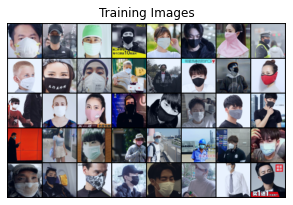

In [6]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels)
    break
    
import numpy as np
plt.figure(figsize=(5, 8))
plt.axis("off")
plt.title(
    "Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[80:120], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))



In [7]:
for images, labels in test_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels)
    break

# load mobilenet_v2
model = torch.hub.load('pytorch/vision:v0.9.0',
                                              'mobilenet_v2', pretrained=True)
#'resnet18'                       
#model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True) # may need dependency
# model.eval()


Image batch dimensions: torch.Size([80, 3, 70, 70])
Image label dimensions: torch.Size([80])
Class labels of 10 examples: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


Using cache found in /Users/angelaguo/.cache/torch/hub/pytorch_vision_v0.9.0


In [30]:
#model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
# change the last classfication into binary
#model.aux_logits=False
#model.fc = torch.nn.Linear(2048,2)
# change the last classfication into binary
model.classifier[1] = torch.nn.Linear(1280, 2)
model = model.to(DEVICE)

#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                       factor=0.1,
#                                                       verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
#    scheduler=scheduler,
#    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([0, 100])
plt.show()

Epoch: 001/035 | Batch 0000/0061 | Loss: 0.8271


In [ ]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()